In [1]:
import scanpy as sc
import pandas as pd
import numpy as np

from sklearn.metrics.pairwise import euclidean_distances
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests

import pickle as pkl

from matplotlib import rcParams
import matplotlib.pyplot as plt
import seaborn as sb

import scib_metrics as sm
import sys
import os
sys.path.append('/'.join(os.getcwd().split('/')[:-1]+['eval','cleaned','']))
from metrics import ilisi,asw_batch

In [2]:
path='/net/bmc-lab6/data/lab/kellis/users/khrovati/data/'
path_data=path+'datasets/d10_1016_j_cell_2020_08_013/'
path_train=path+'cross_system_integration/retina_adult_organoid/'

In [ ]:
adata=sc.concat([
    sc.concat(
        [sc.read(path_data+'periphery.h5ad'),sc.read(path_data+'fovea.h5ad')],
        label='region',keys =['periphery','fovea'],index_unique='-',join='outer'
    ),sc.read(path_data+'organoid.h5ad')],
    label='material',keys =['adult','organoid'],index_unique='-',join='outer'
)

In [10]:
adata.X=adata.raw.X

C: Unclear what batch may be

In [11]:
adata.obs.filtered_out_cells.sum()

0

In [12]:
pd.crosstab(adata.obs.cell_type,adata.obs.material)

material,adult,organoid
cell_type,,
B cell,37,0
Mueller cell,12093,10542
OFF-bipolar cell,3926,686
ON-bipolar cell,2130,1672
T cell,459,0
amacrine cell,1062,1311
astrocyte,321,55
endothelial cell of vascular tree,576,0
fibroblast,1607,0


In [13]:
adata.obs.cell_type.isna().sum()

0

/net/bmc-lab5/data/kellis/users/khrovati/miniconda/envs/analysis/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/net/bmc-lab5/data/kellis/users/khrovati/miniconda/envs/analysis/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/net/bmc-lab5/data/kellis/users/khrovati/miniconda/envs/analysis/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/net/bmc-lab5/data/kellis/users/khrovati/miniconda/envs/analysis/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


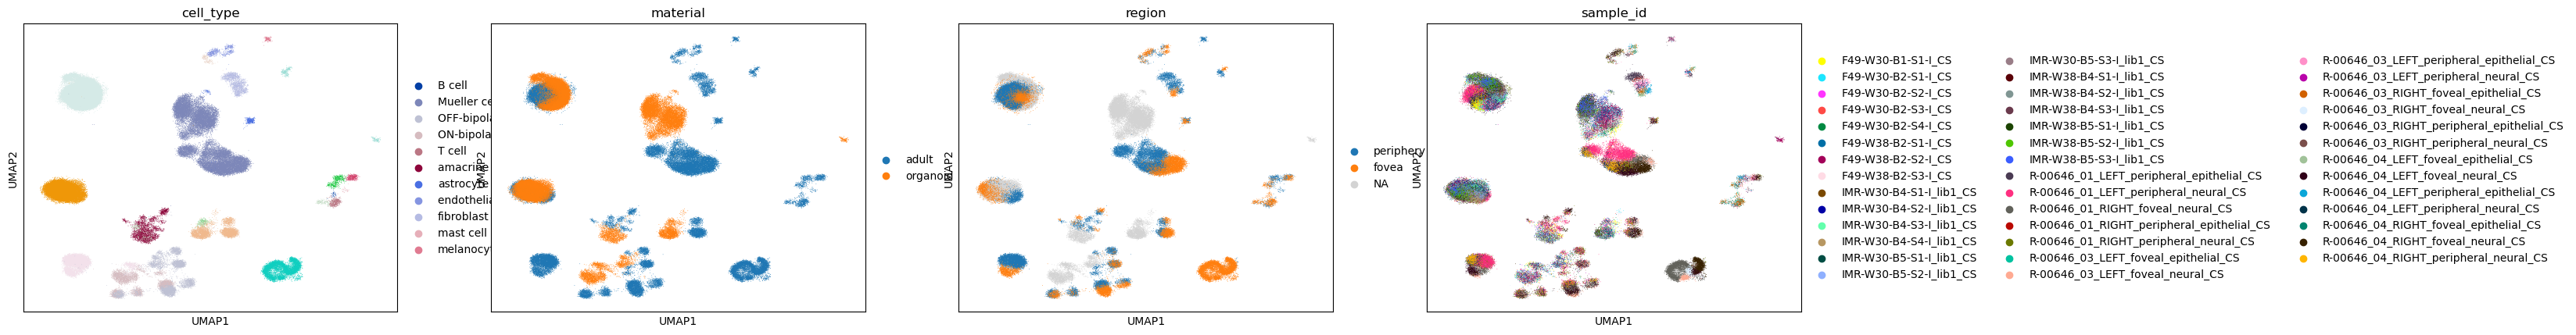

In [14]:
sc.pl.umap(adata,color=['cell_type','material','region','sample_id'])

## Prepare data for training

In [27]:
adata_sub=adata.copy()

In [28]:
# Remove unnanotated cells
adata_sub=adata_sub[adata_sub.obs.cell_type!='native cell',:]

In [29]:
# Keep not too lowly expressed genes as intersection of the two systems
adata_sub=adata_sub[:,
                    np.array((adata_sub[adata_sub.obs.material=="adult",:].X>0).sum(axis=0)>20).ravel()&\
                    np.array((adata_sub[adata_sub.obs.material=="organoid",:].X>0).sum(axis=0)>20).ravel()
                   ]

In [30]:
adata_sub.shape

(97996, 22428)

In [31]:
# Normalize and log scale
# Can normalize together as just CPM
sc.pp.normalize_total(adata_sub, target_sum=1e4)
sc.pp.log1p(adata_sub)

/net/bmc-lab5/data/kellis/users/khrovati/miniconda/envs/analysis/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [32]:
hvgs=set(sc.pp.highly_variable_genes(
    adata_sub[adata_sub.obs.material=="adult",:], 
    n_top_genes=4000, flavor='cell_ranger', inplace=False, batch_key='sample_id').query('highly_variable==True').index)&\
set(sc.pp.highly_variable_genes(
    adata_sub[adata_sub.obs.material=="organoid",:], 
    n_top_genes=4000, flavor='cell_ranger', inplace=False, batch_key='sample_id').query('highly_variable==True').index)
print(len(hvgs))

2001


In [33]:
adata_sub=adata_sub[:,list(hvgs)]

In [34]:
adata_sub.obs['system']=adata_sub.obs['material'].map({"organoid":0,'adult':1})

/tmp/ipykernel_11354/582593205.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_sub.obs['system']=adata_sub.obs['material'].map({"organoid":0,'adult':1})


In [35]:
del adata_sub.uns
del adata_sub.obsm
adata_sub.obs=adata_sub.obs[[
    'cell_type','cell_type_group','author_cell_type','condition', 
    'dataset','sample_id','ega_sample_alias', 'hca_data_portal_donor_uuid', 'hca_data_portal_cellsuspension_uuid', 
    'region',  'material', 'system']]

In [36]:
adata_sub.layers['counts']=adata[adata_sub.obs_names,adata_sub.var_names].X.copy()

Add PCA for scGLUE

In [37]:
# PCA per system
n_pcs=15
X_pca_system=[]
for system in adata_sub.obs.system.unique():
    adata_temp=adata_sub[adata_sub.obs.system==system,:].copy()
    sc.pp.scale(adata_temp)
    sc.pp.pca(adata_temp, n_comps=n_pcs)
    X_pca_system.append(pd.DataFrame(adata_temp.obsm['X_pca'],index=adata_temp.obs_names))
del adata_temp
X_pca_system=pd.concat(X_pca_system)
adata_sub.obsm['X_pca_system']=X_pca_system.loc[adata_sub.obs_names,:].values

### Save

In [38]:
adata_sub

AnnData object with n_obs × n_vars = 97996 × 2001
    obs: 'cell_type', 'cell_type_group', 'author_cell_type', 'condition', 'dataset', 'sample_id', 'ega_sample_alias', 'hca_data_portal_donor_uuid', 'hca_data_portal_cellsuspension_uuid', 'region', 'material', 'system'
    obsm: 'X_pca_system'
    layers: 'counts'

In [41]:
adata_sub.write(path_train+'combined_HVG.h5ad')

In [4]:
#adata_sub=sc.read(path_train+'combined_HVG.h5ad')

# Non-integrated embedding

In [7]:
# Non-integrated embedding
n_pcs=15
cells_eval=np.random.RandomState(seed=0).permutation(adata_sub.obs_names)[:100000]
adata_temp=adata_sub[cells_eval,:].copy()
sc.pp.scale(adata_temp)
sc.pp.pca(adata_temp, n_comps=n_pcs)
sc.pp.neighbors(adata_temp, use_rep='X_pca')
sc.tl.umap(adata_temp)

In [8]:
# Slimmed down data for saving
adata_embed=sc.AnnData(adata_temp.obsm['X_pca'],obs=adata_temp.obs)
for k in ['pca','neighbors','umap']:
    adata_embed.uns[k]=adata_temp.uns[k]
adata_embed.obsm['X_umap']=adata_temp.obsm['X_umap']
for k in ['distances', 'connectivities']:
    adata_embed.obsp[k]=adata_temp.obsp[k]
display(adata_embed)

AnnData object with n_obs × n_vars = 97996 × 15
    obs: 'cell_type', 'cell_type_group', 'author_cell_type', 'condition', 'dataset', 'sample_id', 'ega_sample_alias', 'hca_data_portal_donor_uuid', 'hca_data_portal_cellsuspension_uuid', 'region', 'material', 'system'
    uns: 'pca', 'neighbors', 'umap'
    obsm: 'X_umap'
    obsp: 'distances', 'connectivities'

In [10]:
# Save
adata_embed.write(path_train+'combined_HVG_embed.h5ad')

# Integration metrics on non-integrated data

In [3]:
# Reload
#adata_embed=sc.read(path_train+'combined_HVG_embed.h5ad')

In [19]:
ilisi_system, ilisi_system_macro, ilisi_system_data_label=ilisi(
        X=adata_embed.obsp['distances'],
        batches=adata_embed.obs['system'], 
        labels=adata_embed.obs['cell_type'])

In [20]:
ilisi_system, ilisi_system_macro, ilisi_system_data_label

(0.0,
 0.0,
 label
 B cell                               0.0
 Mueller cell                         0.0
 OFF-bipolar cell                     0.0
 ON-bipolar cell                      0.0
 T cell                               0.0
 amacrine cell                        0.0
 astrocyte                            0.0
 endothelial cell of vascular tree    0.0
 fibroblast                           0.0
 mast cell                            0.0
 melanocyte                           0.0
 microglial cell                      0.0
 monocyte                             0.0
 natural killer cell                  0.0
 pericyte                             0.0
 retina horizontal cell               0.0
 retinal cone cell                    0.0
 retinal ganglion cell                0.0
 retinal pigment epithelial cell      0.0
 retinal rod cell                     0.0
 rod bipolar cell                     0.0
 dtype: float32)

In [23]:
sm.graph_connectivity( X=adata_embed.obsp['distances'],
        labels=adata_embed.obs['system'])

0.6181553954693889

Text(0.5, 0, 'PCs')

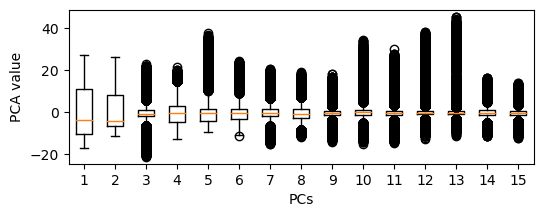

In [25]:
rcParams['figure.figsize']=(6,2)
_=plt.boxplot(adata_embed.X)
plt.ylabel('PCA value')
plt.xlabel('PCs')

In [4]:
asw, asw_macro, asw_data_label=asw_batch(
    X=adata_embed.X,
    batches=adata_embed.obs['system'], 
    labels=adata_embed.obs['cell_type'])

In [8]:
asws={
    'asw_micro':asw,
    'asw_macro':asw_macro,
    'asw_data_label':asw_data_label
}
for k,v in asws.items():
    print(k)
    print(v)
    print('\n')

asw_micro
0.23218098


asw_macro
0.26968095


asw_data_label
Mueller cell                       0.247776
OFF-bipolar cell                   0.338165
ON-bipolar cell                    0.265953
amacrine cell                      0.395107
astrocyte                          0.301310
retina horizontal cell             0.278023
retinal cone cell                  0.270566
retinal pigment epithelial cell    0.236499
retinal rod cell                   0.164146
rod bipolar cell                   0.199265
dtype: float32




In [9]:
pkl.dump({'asw_batch':asws},open(path_train+'combined_HVG_embed_integrationMetrics.pkl','wb'))

# Moran's I for eval

In [42]:
#adata=adata_sub

In [11]:
#adata=sc.read(path_train+'combined_HVG.h5ad')

In [43]:
# Potential groups to compute Moran's I on (batch-system and group)
cols=pd.get_option('display.max_columns')
pd.set_option('display.max_columns', 30)
display(pd.crosstab(adata.obs.sample_id,adata.obs.cell_type))
pd.set_option('display.max_columns', cols)

cell_type,B cell,Mueller cell,OFF-bipolar cell,ON-bipolar cell,T cell,amacrine cell,astrocyte,endothelial cell of vascular tree,fibroblast,mast cell,melanocyte,microglial cell,monocyte,natural killer cell,pericyte,retina horizontal cell,retinal cone cell,retinal ganglion cell,retinal pigment epithelial cell,retinal rod cell,rod bipolar cell
sample_id,,,,,,,,,,,,,,,,,,,,,
F49-W30-B1-S1-I_CS,0,710,89,224,0,212,0,0,0,0,0,0,0,0,0,176,183,0,0,1102,76
F49-W30-B2-S1-I_CS,0,309,23,178,0,22,0,0,0,0,0,0,0,0,0,103,615,0,0,500,23
F49-W30-B2-S2-I_CS,0,530,39,114,0,69,0,0,0,0,0,0,0,0,0,161,490,0,4,391,27
F49-W30-B2-S3-I_CS,0,628,25,199,0,57,0,0,0,0,0,0,0,0,0,172,285,0,6,291,43
F49-W30-B2-S4-I_CS,0,693,37,138,0,25,0,0,0,0,0,0,0,0,0,260,457,0,0,285,34
F49-W38-B2-S1-I_CS,0,1371,168,247,0,68,1,0,0,0,0,0,0,0,0,210,824,0,6,925,76
F49-W38-B2-S2-I_CS,0,1255,80,274,0,111,5,0,0,0,0,0,0,0,0,94,591,0,114,853,65
F49-W38-B2-S3-I_CS,0,724,40,168,0,26,0,0,0,0,0,0,0,0,0,104,842,0,0,572,30
IMR-W30-B4-S1-I_lib1_CS,0,207,10,4,0,35,1,0,0,0,0,0,0,0,0,20,790,0,0,581,3


In [44]:
# Filtered groups based on N cells
groups=adata.obs.groupby(['cell_type','system','sample_id']).size()
groups=groups[groups>=500]
rows=pd.get_option('display.max_rows')
pd.set_option('display.max_rows', 100)
display(groups)
pd.set_option('display.max_rows', rows)
print('N cell types',groups.index.get_level_values('cell_type').nunique())

cell_type              system  sample_id                            
Mueller cell           1       R-00646_01_LEFT_peripheral_neural_CS     3928
                               R-00646_01_RIGHT_foveal_neural_CS        1130
                               R-00646_01_RIGHT_peripheral_neural_CS    2053
                               R-00646_04_LEFT_foveal_neural_CS         1048
                               R-00646_04_LEFT_peripheral_neural_CS      726
                               R-00646_04_RIGHT_foveal_neural_CS        1001
                               R-00646_04_RIGHT_peripheral_neural_CS     772
                       0       F49-W30-B1-S1-I_CS                        710
                               F49-W30-B2-S2-I_CS                        530
                               F49-W30-B2-S3-I_CS                        628
                               F49-W30-B2-S4-I_CS                        693
                               F49-W38-B2-S1-I_CS                       1371
       

N cell types 8


In [45]:
# Compute Moran's I per group
data=[]
for group in groups.index:
    # Group adata
    print(group)
    adata_sub=adata[
        (adata.obs.cell_type==group[0]).values&\
        (adata.obs.system==group[1]).values&\
        (adata.obs.sample_id==group[2]).values,:].copy()
    # Remove lowly expr genes before Moran's I computation as they will be less likely relevant
    # As this is done per small cell group within sample+cell type there is not many genes (200-500)
    # so all can be used for Moran's I computation
    sc.pp.filter_genes(adata_sub, min_cells=adata_sub.shape[0]*0.1) 
    # Compute embedding of group
    sc.pp.pca(adata_sub, n_comps=15)
    sc.pp.neighbors(adata_sub, n_pcs=15)
    # Compute I
    morans_i=sc.metrics._morans_i._morans_i(
        g=adata_sub.obsp['connectivities'],
        vals=adata_sub.X.T)
    # Save data
    morans_i=pd.DataFrame({'morans_i':morans_i},index=adata_sub.var_names)
    morans_i['group']=group[0]
    morans_i['system']=group[1]
    morans_i['batch']=group[2]
    data.append(morans_i)
data=pd.concat(data,axis=0)

('Mueller cell', 1, 'R-00646_01_LEFT_peripheral_neural_CS')


/net/bmc-lab5/data/kellis/users/khrovati/miniconda/envs/analysis/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


('Mueller cell', 1, 'R-00646_01_RIGHT_foveal_neural_CS')
('Mueller cell', 1, 'R-00646_01_RIGHT_peripheral_neural_CS')
('Mueller cell', 1, 'R-00646_04_LEFT_foveal_neural_CS')
('Mueller cell', 1, 'R-00646_04_LEFT_peripheral_neural_CS')
('Mueller cell', 1, 'R-00646_04_RIGHT_foveal_neural_CS')
('Mueller cell', 1, 'R-00646_04_RIGHT_peripheral_neural_CS')
('Mueller cell', 0, 'F49-W30-B1-S1-I_CS')
('Mueller cell', 0, 'F49-W30-B2-S2-I_CS')
('Mueller cell', 0, 'F49-W30-B2-S3-I_CS')
('Mueller cell', 0, 'F49-W30-B2-S4-I_CS')
('Mueller cell', 0, 'F49-W38-B2-S1-I_CS')
('Mueller cell', 0, 'F49-W38-B2-S2-I_CS')
('Mueller cell', 0, 'F49-W38-B2-S3-I_CS')
('Mueller cell', 0, 'IMR-W38-B4-S3-I_lib1_CS')
('Mueller cell', 0, 'IMR-W38-B5-S1-I_lib1_CS')
('OFF-bipolar cell', 1, 'R-00646_01_LEFT_peripheral_neural_CS')
('OFF-bipolar cell', 1, 'R-00646_01_RIGHT_foveal_neural_CS')
('OFF-bipolar cell', 1, 'R-00646_01_RIGHT_peripheral_neural_CS')
('OFF-bipolar cell', 1, 'R-00646_03_LEFT_foveal_neural_CS')
('OFF-bipo

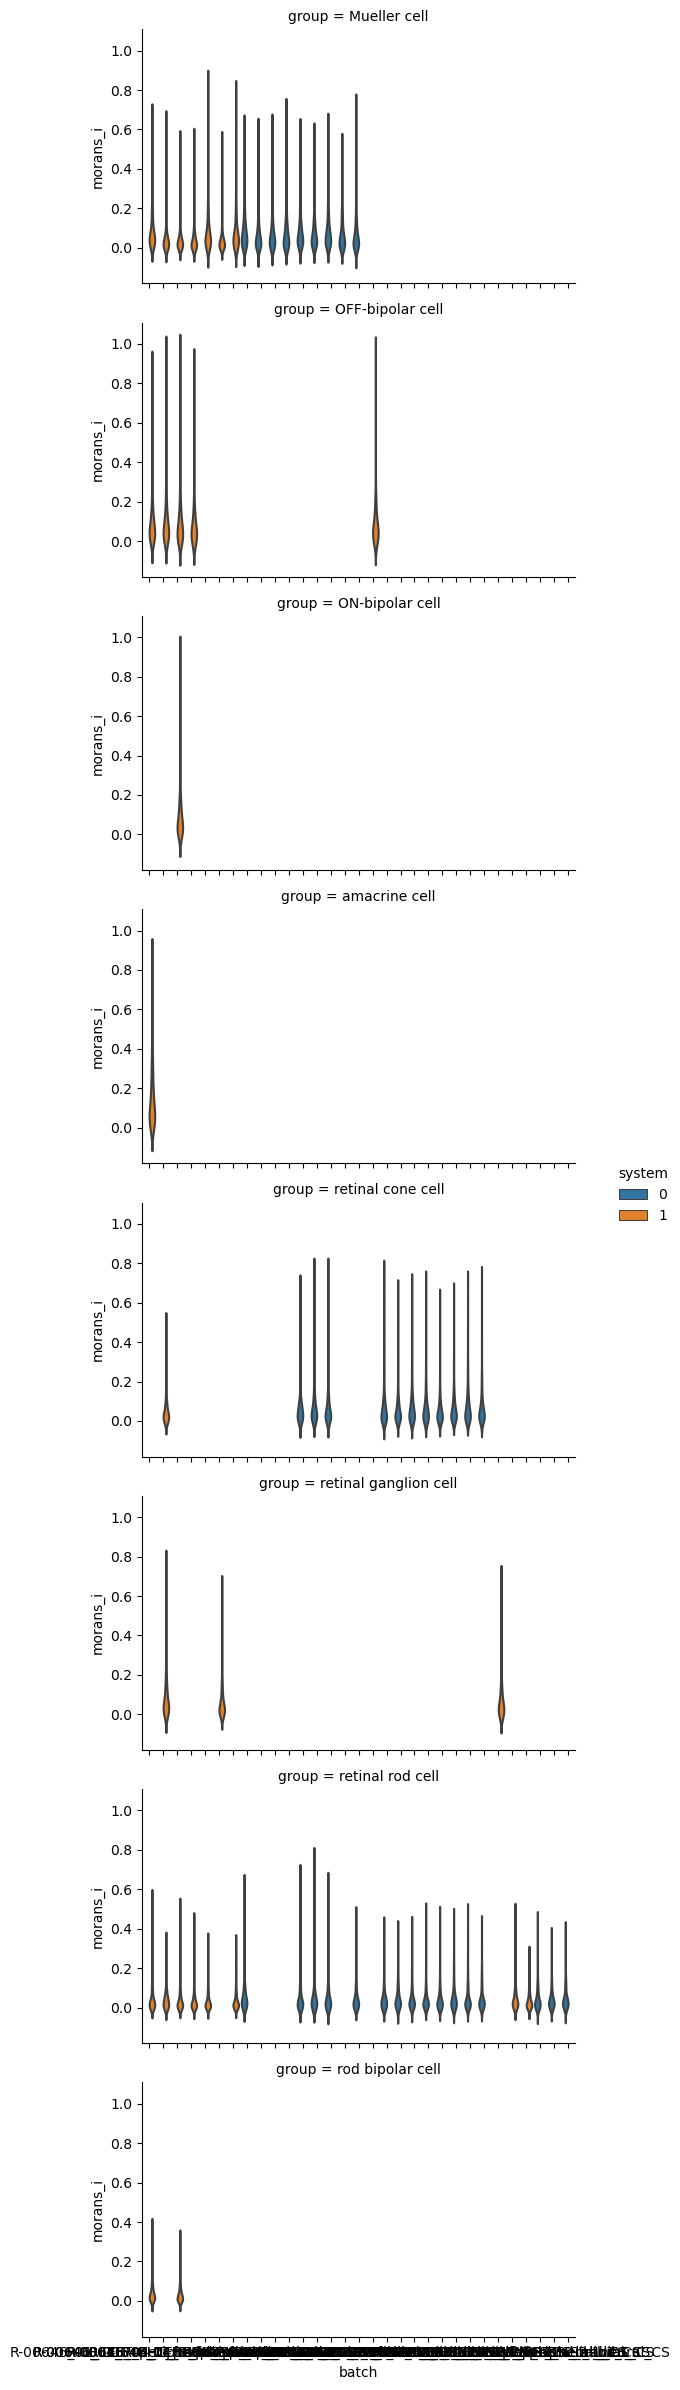

In [46]:
# Moran's I distn accross groups
sb.catplot(x='batch',y='morans_i',hue='system',row='group',data=data,kind='violin',
           inner=None,height=3,aspect=2)

In [47]:
# I thr
thr_mi=0.15

In [48]:
# N genes per group at certain thr
rows=pd.get_option('display.max_rows')
pd.set_option('display.max_rows', 100)
display(data.groupby(['group','system','batch']).apply(lambda x: (x['morans_i']>=thr_mi).sum()))
pd.set_option('display.max_rows', rows)

group                  system  batch                                
Mueller cell           0       F49-W30-B1-S1-I_CS                       134
                               F49-W30-B2-S2-I_CS                        99
                               F49-W30-B2-S3-I_CS                       114
                               F49-W30-B2-S4-I_CS                       153
                               F49-W38-B2-S1-I_CS                       132
                               F49-W38-B2-S2-I_CS                       108
                               F49-W38-B2-S3-I_CS                       131
                               IMR-W38-B4-S3-I_lib1_CS                  132
                               IMR-W38-B5-S1-I_lib1_CS                  125
                       1       R-00646_01_LEFT_peripheral_neural_CS     143
                               R-00646_01_RIGHT_foveal_neural_CS         44
                               R-00646_01_RIGHT_peripheral_neural_CS     44
                   

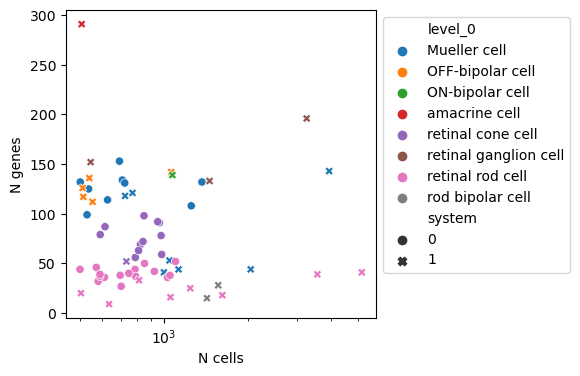

In [49]:
# N genes vs N cells in group
rcParams['figure.figsize']=(4,4)
sb.scatterplot(x='N cells',y='N genes',hue='level_0',style='system',
           data=pd.concat(
    [data.groupby(['group','system','batch']).apply(lambda x: (x['morans_i']>=thr_mi).sum()).rename('N genes'),
    groups.rename('N cells')],axis=1).reset_index())
plt.legend(bbox_to_anchor=(1,1))
plt.xscale('log')

C: Thr of 0.15 has at least some genes for every group and not too many in any of the groups. Some groups would need lower/higher thr potentially.

C: There is no clear bias between N cells in group and N genes, although such bias was observed within a cell type accross genes. Likely due to sample/cell type specific effects.

C: Selected genes may not be diverse though - they may capture the same pattern and maybe more subtle patterns are at lower Moran's I.

In [50]:
# Prepare selected genes for saving (fileterd genes&I per group)
selected=list()
for group,data_sub in data.groupby(['group','system','batch']):
    group=dict(zip(['group','system','batch'],group))
    group['genes']=(data_sub.query('morans_i>=@thr_mi')['morans_i']+1)/2
    selected.append(group)

In [51]:
# Save
pkl.dump(selected,open(path_train+'combined_HVG_moransiGenes.pkl','wb'))

In [54]:
path_train

'/net/bmc-lab6/data/lab/kellis/users/khrovati/data/cross_system_integration/retina_adult_organoid/'

# Batch effects within and between systems

In [18]:
#adata=sc.read(path_train+'combined_HVG.h5ad')

In [8]:
# Compute PCA on the whole data
adata_scl=adata.copy()
sc.pp.scale(adata_scl)
n_pcs=15
sc.pp.pca(adata_scl, n_comps=n_pcs)
pca=pd.DataFrame(adata_scl.obsm['X_pca'],index=adata_scl.obs_names)
del adata_scl

In [9]:
# Average PCA accross system-batch-group pseudobulks. 
# Only use pseudobulks with at least 50 cells
# Only use cell types with at least 3 samples per system
pca[['system','batch','group']]=adata.obs[['system', 'sample_id', 'cell_type']]
pca_pb=pca.groupby(['system','batch','group'])
pca_mean=pca_pb.mean()
pb_size=pca_pb.size()
# Remove samples with too little cells
filtered_pb=pb_size.index[pb_size>=50]
# Get pbs/cts where both systems have enough samples
n_samples_system=filtered_pb.to_frame().rename({'group':'group_col'},axis=1).groupby(
    'group_col',observed=True)['system'].value_counts().rename('n_samples').reset_index()
cts=set(n_samples_system.query('system==0 & n_samples>=3').group_col)&\
    set(n_samples_system.query('system==1 & n_samples>=3').group_col)
filtered_pb=filtered_pb[filtered_pb.get_level_values(2).isin(cts)]
pca_mean=pca_mean.loc[filtered_pb,:]

In [10]:
# Compute per-ct distances of samples within and between systems
distances={}
for ct in cts:
    pca_s0=pca_mean[(pca_mean.index.get_level_values(0)==0) &
                    (pca_mean.index.get_level_values(2)==ct)]
    pca_s1=pca_mean[(pca_mean.index.get_level_values(0)==1) &
                    (pca_mean.index.get_level_values(2)==ct)]
    d_s0=euclidean_distances(pca_s0)[np.triu_indices(pca_s0.shape[0],k=1)]
    d_s1=euclidean_distances(pca_s1)[np.triu_indices(pca_s1.shape[0],k=1)]
    d_s0s1=euclidean_distances(pca_s0,pca_s1).ravel()
    distances[ct]={'s0':d_s0,'s1':d_s1,'s0s1':d_s0s1}

In [11]:
# Save distances
pkl.dump(distances,open(path_train+'combined_HVG_PcaSysBatchDist.pkl','wb'))

In [3]:
# Reload distances
#distances=pkl.load(open(path_train+'combined_HVG_PcaSysBatchDist.pkl','rb'))

In [12]:
# Prepare df for plotting
plot=[]
for ct,dat in distances.items():
    for comparison,dist in dat.items():
        dist=pd.DataFrame(dist,columns=['dist'])
        dist['group']=ct
        dist['comparison']=comparison
        plot.append(dist)
plot=pd.concat(plot)

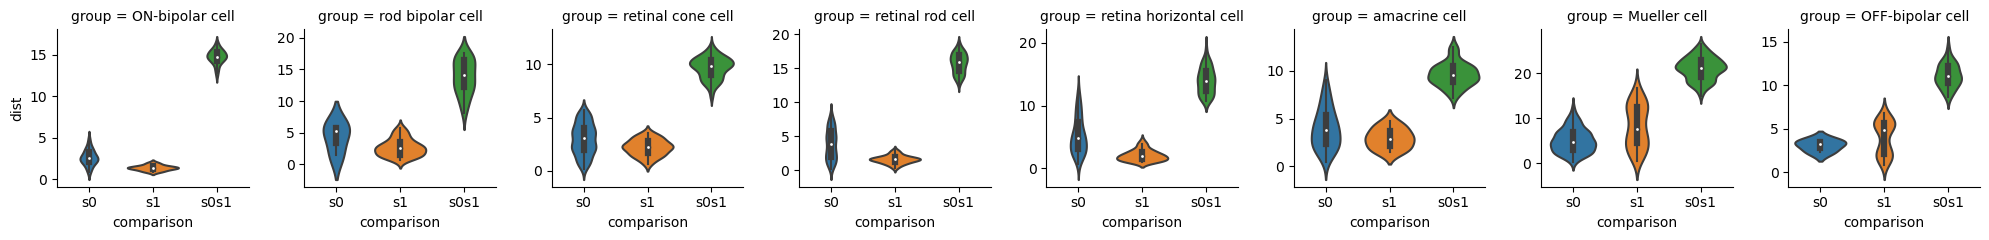

In [15]:
# Plot distances
sb.catplot(x='comparison',y='dist',col='group',
           data=plot.reset_index(drop=True),kind='violin',
           sharey=False, height=2.5,aspect=1 )

Evaluate statisticsal significance

In [24]:
# Compute significance of differences within and accross systems
signif=[]
for ct,dat in distances.items():
    for ref in ['s0','s1']:
        u,p=mannwhitneyu( dat[ref],dat['s0s1'],alternative='less')
        signif.append(dict( cell_type=ct,system=ref, u=u,pval=p,
                           n_system=dat[ref].shape[0],n_crossystem=dat['s0s1'].shape[0]))
signif=pd.DataFrame(signif)
signif['padj']=multipletests(signif['pval'],method='fdr_bh')[1]

In [25]:
signif

,cell_type,system,u,pval,n_system,n_crossystem,padj
0,ON-bipolar cell,s0,0.0,2.399227e-13,28,48,3.198970e-13
1,ON-bipolar cell,s1,0.0,3.288052e-09,15,48,3.757774e-09
2,rod bipolar cell,s0,0.0,1.400560e-04,3,33,1.400560e-04
3,rod bipolar cell,s1,0.0,2.695407e-15,55,33,3.920592e-15
4,retinal cone cell,s0,0.0,1.303458e-70,210,210,6.951778e-70
5,retinal cone cell,s1,0.0,3.409498e-26,45,210,7.793139e-26
6,retinal rod cell,s0,0.0,7.036008e-74,210,231,5.628807e-73
7,retinal rod cell,s1,0.0,5.040256e-31,55,231,2.016102e-30
8,retina horizontal cell,s0,56.0,5.532404e-29,66,120,1.475308e-28
9,retina horizontal cell,s1,0.0,2.620078e-23,45,120,5.240155e-23


In [26]:
# Save signif
signif.to_csv(path_train+'combined_HVG_PcaSysBatchDist_Signif.tsv',sep='\t',index=False)

AUC based on Mann-Whitney U (using within system as one group and between system as the other)

In [14]:
auc_roc={}
for ct,dat in distances.items():
    x_within=np.concatenate([dat['s0'],dat['s1']])
    x_between=dat['s0s1']
    auc_roc[ct]=mannwhitneyu(x_between,x_within)[0]/(x_within.shape[0]*x_between.shape[0])
print(auc_roc)

{'ON-bipolar cell': 1.0, 'rod bipolar cell': 1.0, 'retinal cone cell': 1.0, 'retinal rod cell': 1.0, 'retina horizontal cell': 0.9957957957957958, 'amacrine cell': 0.9911255411255411, 'Mueller cell': 0.9997386261537204, 'OFF-bipolar cell': 1.0}
